In [3]:
import pandas as pd
import numpy as np
import json
import folium
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA

# Getting and cleaning the data

## Correspondence between the FSAs of 2016 and 2020

The FSAs have evolved since the census in 2016. The main part of them is similar, but some have changed. So, we will group the FSAs that have changed in order to have similar territories for the data from 2016 and the data from 2020.

In [4]:
def process_fsa(fsa, year):
    if year == 2020:
        fsas = {'H3A': 'H3A-H3B', 'H3B': 'H3A-H3B',
                'H8S': 'H8S-H8T', 'H8T': 'H8S-H8T',
                'H9J': 'H9J-H9K', 'H9K': 'H9J-H9K',
                'H4Y': 'H9P', 'H9P': 'H9P',
                'H5B': 'H2Z',
                'H5A': 'H3A-H3B', 'H4Z': 'H3A-H3B',
                'H4R': 'H4R-H4S-H4T', 'H4S': 'H4R-H4S-H4T', 'H4T': 'H4R-H4S-H4T'}
    if year == 2016:
        fsas = {'H3A': 'H3A-H3B', 'H3B': 'H3A-H3B',
                'H8S': 'H8S-H8T', 'H8T': 'H8S-H8T',
                'H9J': 'H9J-H9K', 'H9K': 'H9J-H9K',
                'H4R': 'H4R-H4S-H4T', 'H4S': 'H4R-H4S-H4T'}
    if fsa in fsas:
        return fsas[fsa]
    else:
        return fsa

## Foursquare

In [5]:
# Export the foursquare dataset
foursquare = pd.read_csv('../data/foursquare/all.csv')

# Drop duplicates
foursquare.drop_duplicates(subset = 'id', inplace=True, ignore_index=True)

# Process the data to group categories
def process_categories(category_name):
    
    # Restaurant and Bar
    restaurant = ['restaurant', 'bar', 'café', 'cafe', 'coffee', 'pizza', 'sandwich', 'breakfast spot', 'ice cream',
                  'frozen yogurt', 'speakeasy', 'nightlife', 'diner', 'lounge', 'joint', 'snack', 'bistro', 'food truck',
                  'brewery', 'strip club', 'pub', 'nightclub', 'food court', 'steakhouse', 'tea room', 'taco', 'castle',
                  'creperie', 'buffet', 'food service', 'bath house', 'poke place', 'soup place', 'club house',
                  'fish & chips', 'burrito', 'poutine', 'noodle', 'brasserie', 'well', 'salad place', 'beer garden']
    for r in restaurant:
        if r in str(category_name).lower() and str(category_name) not in ['Salon / Barbershop', 'Piano Bar', 'Public Art']:
            return 'RestaurantBar'
    
    # Entertainment
    entertainment = ['museum', 'theater', 'entertainment', 'event space', 'art gallery', 'performing', 'public art',
                     'art studio', 'library', 'design', 'music venue', 'comedy', 'photography', 'sculpture',
                     'convention center', 'arcade', 'bowling', 'recreation', 'rock', 'jazz', 'concert', 'auditorium',
                     'water', 'monument', 'lighthouse', 'exhibit', 'planetarium', 'recording studio', 'memorial site',
                     'piano', 'circus', 'zoo', 'massage', 'casino', 'play area']
    for e in entertainment:
        if e in str(category_name).lower() and 'college' not in str(category_name).lower() or str(category_name) == 'Spa':
            return 'EntertainmentCulture'
    
    # Sports
    sports = ['pool', 'gym', 'sports', 'field', 'studio', 'court', 'rink', 'golf', 'arena', 'track', 'stadium',
              'skate', 'range', 'dojo', 'curling']
    for s in sports:
        if s in str(category_name).lower():
            return 'Sports'
    
    # Outdoor
    outdoor = ['park', 'outdoor', 'scenic lookout', 'site', 'garden', 'marina', 'boat', 'plaza', 'trail', 'mountain', 'surf',
               'campground', 'lake', 'beach', 'rest area', 'vineyard', 'forest', 'nature', 'cave', 'fishing', 'rafting']
    for o in outdoor:
        if o in str(category_name).lower():
            return 'Outdoor'
    
    # All other
    if pd.isna(category_name):
        category = 'Other'

    return 'Other'

foursquare['Category'] = foursquare['category_name'].apply(process_categories)
# Process the FSA to make correspondance between 2016 and 2020
foursquare['FSA'] = foursquare['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by categories to get the number of venues for each category per FSA
foursquare = foursquare[['FSA', 'id', 'Category']].groupby(['FSA', 'Category']).agg(NbVenue=('id','count')).reset_index()
foursquare.head()

FSA              Category  NbVenue
0  H1A  EntertainmentCulture        3
1  H1A                 Other       67
2  H1A               Outdoor       10
3  H1A         RestaurantBar        7
4  H1A                Sports        9

## STM

In [6]:
# Read the CSV file with the metro stations per FSA
metro_stations = pd.read_csv('../data/metro/metro_stations.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
metro_stations['FSA'] = metro_stations['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of stations per FSA
metro_stations = metro_stations.groupby(['FSA']).agg(MetroStations=('Name', 'count')).reset_index()
metro_stations.head()

FSA  MetroStations
0  H1L              1
1  H1N              4
2  H1V              1
3  H1W              3
4  H2A              1

## Daycares

In [7]:
# Get the data from the CSV file
daycare = pd.read_csv('../data/daycare/liste-des-services-de-garde-07.csv', engine='python')

# Keep only the daycares in the Montreal island
def mtl_fsa(postal_code):
    if postal_code[0:2] in ['H1', 'H2', 'H3', 'H4', 'H5', 'H8', 'H9']:
        return True
    else:
        return False
daycare = daycare[daycare['CODE_POSTAL_COMPO'].apply(mtl_fsa)].reset_index(drop=True)
daycare['FSA'] = daycare['CODE_POSTAL_COMPO'].apply(lambda x: x[0:3])

# Process the FSA to make correspondance between 2016 and 2020
daycare['FSA'] = daycare['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of daycares per FSA
daycare = daycare.groupby(['FSA']).agg(Daycare=('ADRESSE','count')).reset_index()
daycare.head()

FSA  Daycare
0  H1A       14
1  H1B       10
2  H1C        8
3  H1E       28
4  H1G       26

## Schools

In [8]:
# Get the data from the CSV files
college = pd.read_csv('../data/schools/ES_Collegial.csv', sep=';')
univ = pd.read_csv('../data/schools/ES_Universitaire.csv', sep=';')
pps_gouv = pd.read_csv('../data/schools/PPS_Gouvernemental.csv', sep=';')
pps_prive = pd.read_csv('../data/schools/PPS_Prive_Installation.csv', sep=';')
pps_public = pd.read_csv('../data/schools/PPS_Public_Ecole.csv', sep=';')
pps_public.rename(columns={'CD_POSTL_GDUNO_ORGNS': 'CD_POSTL_GDUNO'}, inplace=True)

# Keep only the schools in the Montreal island
def mtl_fsa(postal_code):
    if postal_code[0:2] in ['H1', 'H2', 'H3', 'H4', 'H5', 'H8', 'H9']:
        return True
    else:
        return False
college = college[college['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
univ = univ[univ['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_gouv = pps_gouv[pps_gouv['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_prive = pps_prive[pps_prive['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)
pps_public = pps_public[pps_public['CD_POSTL_GDUNO'].apply(mtl_fsa)].reset_index(drop=True)

# Duplicate rows with multiple school levels and separate the name to have one row for one school level
def school_level(school):
    for i in school.index:
        s = school.loc[i, 'ORDRE_ENS'].split('-')
        if len(s) > 1:
            for j in range(1, len(s)):
                m = max(school.index)+1
                school.loc[m] = school.loc[i]
                school.loc[m, 'ORDRE_ENS'] = s[j]
                if school.loc[m, 'ORDRE_ENS'][0] == ' ':
                    school.loc[m, 'ORDRE_ENS'] = school.loc[m, 'ORDRE_ENS'][1:]
                if school.loc[m, 'ORDRE_ENS'][-1] == ' ':
                    school.loc[m, 'ORDRE_ENS'] = school.loc[m, 'ORDRE_ENS'][:-1]
            school.loc[i, 'ORDRE_ENS'] = s[0]
            school.loc[i, 'ORDRE_ENS'] = school.loc[i, 'ORDRE_ENS'][:-1]
    school.sort_values(by=['OBJECTID'], inplace=True)
    school.reset_index(drop=True, inplace=True)
    return school
pps_prive = school_level(pps_prive)
pps_public = school_level(pps_public)

# Create a dataframe containing all the schools with the FSA and the school level
schools = pd.concat([college[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     univ[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_gouv[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_prive[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']],
                     pps_public[['OBJECTID', 'CD_POSTL_GDUNO', 'ORDRE_ENS']]])
schools['CD_POSTL_GDUNO'] = schools['CD_POSTL_GDUNO'].apply(lambda x: x[0:3])
schools.rename(columns={'OBJECTID': 'SchoolId', 'CD_POSTL_GDUNO': 'FSA', 'ORDRE_ENS': 'Level'}, inplace=True)

# Classify the school level into three categories: PPS (Preschool, Primary school and Secondary school),
# Post-secondary and Professional Training - Adult Education
def classify_school_levels(level):
    if level in ['Préscolaire', 'Primaire', 'Secondaire']:
        return 'PPS'
    if level in ['Collégial', 'Universitaire']:
        return 'PostSecondary'
    if level in ['Éducation aux adultes', 'Formation professionnelle']:
        return 'ProfessionalTraining-AdultEducation'
schools['SchoolType'] = schools['Level'].apply(classify_school_levels)
schools.sort_values(by=['FSA'], inplace=True)

# Process the FSA to make correspondance between 2016 and 2020
schools['FSA'] = schools['FSA'].apply(lambda x: process_fsa(x, 2020))
# Group by FSA to get the number of schools (for each category) per FSA
schools = schools.groupby(['FSA', 'SchoolType']).agg(NbSchool=('SchoolId','count')).reset_index()
schools.head()

FSA                           SchoolType  NbSchool
0  H1A                                  PPS        23
1  H1B                                  PPS        16
2  H1B  ProfessionalTraining-AdultEducation         6
3  H1C                                  PPS        14
4  H1E                                  PPS        15

## Walk score

Let's see all the available and not available walk scores, transit scores and bike scores on the map.

In [43]:
# Data for Montreal
latitude = 45.535433
longitude = -73.636493
mtl_geo_json = "../data/maps/mtl_fsa_map.geojson"
mtl_grp_geo_json = "../data/maps/mtl_fsa_grouped_map.geojson"

# Get the walkscore data
ws = pd.read_csv('../data/walkscore/walkscore.csv', index_col=0)

# Choose the score to visualize
score = 'Walkscore' # 'Walkscore' or 'Transitscore' or 'Bikescore'

# Built the map
nan_ws_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(nan_ws_map)
for lat, lng, score in zip(ws['Latitude'], ws['Longitude'], ws[score]):
    label = folium.Popup(str(score), parse_html=True)
    if np.isnan(score):
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='red',
            parse_html=False).add_to(nan_ws_map)
    else:
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='blue',
            parse_html=False).add_to(nan_ws_map)
nan_ws_map

The available walk scores and bike scores can be processed but the transit scores are not relevant because they are too concentrated on a single geographic area.

In [10]:
# Process the FSA to make correspondance between 2016 and 2020
ws['FSA'] = ws['FSA'].apply(lambda x: process_fsa(x, 2016))
# Get the mean score for each FSA
walkscore = ws.groupby('FSA', as_index=False).mean()
# Drop the transitscore because it is not relevant
walkscore.drop(columns='Transitscore', inplace=True)
walkscore.head()

FSA   Latitude  Longitude  Walkscore  Bikescore
0  H1A  45.670741 -73.505878  19.733766  54.967532
1  H1B  45.635377 -73.523538  15.466165  47.318182
2  H1C  45.669124 -73.534936   3.850877  47.157895
3  H1E  45.638857 -73.583131  31.719298  54.719298
4  H1G  45.612047 -73.620212  49.437500  60.137500

## Census

In [11]:
# Get the census data
census = pd.read_csv('../data/census/census_20200808_1501.csv', index_col=0)
for fsa in ['H4T', 'H4Y', 'H4Z', 'H5A', 'H5B']:
    census = census[census['FSA'] != fsa] # No data for these new FSAs
# Process the FSA to make correspondance between 2016 and 2020
census['FSA'] = census['FSA'].apply(lambda x: process_fsa(x, 2016))
census.head()

Topic CategoryHierId  \
idTopic                           
5        Housing          9.1.5   
5        Housing       9.1.13.5   
5        Housing          9.1.1   
5        Housing          9.1.1   
5        Housing          9.1.1   

                                                  Category TypeHierId  \
idTopic                                                                 
5                     Average number of rooms per dwelling        NaN   
5                            Median value of dwellings ($)        NaN   
5        Total - Private households by tenure - 25% sam...    9.1.1.1   
5        Total - Private households by tenure - 25% sam...    9.1.1.2   
5        Total - Private households by tenure - 25% sam...    9.1.1.3   

                   Type  TypeValue  CategoryValue  FSA  
idTopic                                                 
5                   NaN        NaN            5.5  H1A  
5                   NaN        NaN       259561.0  H1A  
5                 Owner     8625.0        13815.0  H1A  
5                Renter     5190.0        13815.0  H1A  
5          Band housing        0.0        13815.0  H1A

# Creating the master data frames

In [12]:
# Get the average of a column, weighted by another
def weighted_average(df, df_weight, field):
    df = df.join(df_weight.set_index('FSA'), on='FSA')
    d1 = df.drop_duplicates(subset=['FSA'], keep=('first'))
    d2 = df.drop_duplicates(subset=['FSA'], keep=('last'))
    df = pd.concat([d1,d2]).drop_duplicates()
    df['Product'] = df[field] * df['Weight']
    df = df.groupby('FSA', as_index=False).sum()
    df[field] = df['Product'] / df['Weight']
    return df[['FSA', field]]

## Environment data frame

In [13]:
# Get the FSA with their areas to create the master data frame for the FSA environment
df_env = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_env['FSA'] = df_env['FSA'].apply(lambda x: process_fsa(x, 2020))
df_env = df_env.groupby('FSA', as_index=False).sum()

# Add the walkscores and bikescores to the dataframe
df_env = df_env.join(walkscore[['FSA', 'Walkscore', 'Bikescore']].set_index('FSA'), on='FSA')

# Add the foursquare venues
categories = ['RestaurantBar', 'EntertainmentCulture', 'Sports', 'Outdoor']
for category in categories:
    df_temp = foursquare[foursquare['Category'] == category][['FSA', 'NbVenue']]
    df_env = df_env.join(df_temp.rename(columns={'NbVenue': category}).set_index('FSA'), on='FSA')
    # Get the density instead of the number for a better comparison
    df_env[category] = df_env[category] / df_env['Area(km2)']

# Add the metro stations
df_env = df_env.join(metro_stations.set_index('FSA'), on='FSA')
# Get the density instead of the number for a better comparison
df_env['MetroStations'] = df_env['MetroStations'] / df_env['Area(km2)']

# Add the daycares
df_env = df_env.join(daycare.set_index('FSA'), on='FSA')
# Get the density instead of the number for a better comparison
df_env['Daycare'] = df_env['Daycare'] / df_env['Area(km2)']

# Add the schools
school_types = ['PPS', 'PostSecondary']
for school_type in school_types:
    df_temp = schools[schools['SchoolType'] == school_type][['FSA', 'NbSchool']]
    df_env = df_env.join(df_temp.rename(columns={'NbSchool': school_type}).set_index('FSA'), on='FSA')
    # Get the density instead of the number for a better comparison
    df_env[school_type] = df_env[school_type] / df_env['Area(km2)']

# Fill the Nan values with zero
df_env.fillna(0, inplace=True)

df_env.drop(columns=['Area(km2)'], inplace=True)
df_env.round(2).head()

FSA  Walkscore  Bikescore  RestaurantBar  EntertainmentCulture  Sports  \
0  H1A      19.73      54.97           0.46                  0.20    0.59   
1  H1B      15.47      47.32           1.87                  0.67    0.07   
2  H1C       3.85      47.16           0.71                  0.36    0.18   
3  H1E      31.72      54.72           2.70                  0.36    0.45   
4  H1G      49.44      60.14           2.41                  0.51    0.38   

   Outdoor  MetroStations  Daycare   PPS  PostSecondary  
0     0.66            0.0     0.92  1.51           0.00  
1     0.45            0.0     0.75  1.19           0.00  
2     0.54            0.0     0.71  1.25           0.00  
3     0.18            0.0     2.52  1.35           0.00  
4     0.13            0.0     3.29  3.16           0.38

## Population data frame

In [14]:
# Get the FSA with their areas to create the master data frame for the FSA population
df_pop = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_pop['FSA'] = df_pop['FSA'].apply(lambda x: process_fsa(x, 2020))
df_pop = df_pop.groupby('FSA', as_index=False).sum()

# Get the fields from the census we are interested in for the population dataframe
# Population
df_temp = census[census['CategoryHierId'] == '1.1.1'][['FSA', 'CategoryValue']].groupby('FSA', as_index=False).sum()
df_pop = df_pop.join(df_temp.rename(columns={'CategoryValue': 'Population'}).set_index('FSA'), on='FSA')
# Get the density of population instead of the number for a better comparison
df_pop['Population'] = df_pop['Population'] / df_pop['Area(km2)']

# Age, Income
fields = {'Age': '1.2.4',
          'Income': '4.1.1.1.1'}
for field in fields:
    # for grouped FSA: take the population-weighted average
    df_temp = census[census['CategoryHierId'] == fields[field]][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': field})
    df_weight = census[census['CategoryHierId'] == '1.1.1'][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': 'Weight'})
    df_temp = weighted_average(df_temp, df_weight, field)
    df_pop = df_pop.join(df_temp.set_index('FSA'), on='FSA')

# Family types
df_temp = census[census['TypeHierId'] == '2.3.4.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'ChildlessCouples'}).groupby('FSA', as_index=False).sum()
fields = {'CouplesWithChildren': ['2.3.4.2', 'TypeValue'],
          'LoneWithChildren': ['2.3.5.1', 'CategoryValue'],
          'OnePerson': ['2.4.1.3.1', 'TypeValue'],
          'SeveralNoFamily': ['2.4.1.3.2', 'TypeValue']}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field][0]][['FSA', fields[field][1]]].rename(
        columns={fields[field][1]: field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['FamiliesWithChildren'] = df_temp['CouplesWithChildren'] + df_temp['LoneWithChildren']
columns = ['ChildlessCouples', 'FamiliesWithChildren', 'OnePerson', 'SeveralNoFamily']
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_pop = df_pop.join(df_temp[['FSA',
                              'ChildlessCouples(%)',
                              'FamiliesWithChildren(%)',
                              'OnePerson(%)',
                              'SeveralNoFamily(%)']].set_index('FSA'), on='FSA')

df_pop.drop(columns=['Area(km2)'], inplace=True)
df_pop.round(2).head()

FSA  Population   Age   Income  ChildlessCouples(%)  \
0  H1A     2139.21  46.3  35303.0                25.93   
1  H1B     1504.48  44.0  31150.0                23.20   
2  H1C     1310.54  37.1  36786.0                21.00   
3  H1E     3821.62  43.5  28969.0                22.51   
4  H1G     6146.33  41.4  23258.0                17.08   

   FamiliesWithChildren(%)  OnePerson(%)  SeveralNoFamily(%)  
0                    38.95         31.47                3.65  
1                    36.57         35.92                4.31  
2                    62.28         14.94                1.78  
3                    50.07         25.17                2.24  
4                    44.48         33.56                4.88

## Housing data frame

In [15]:
# Get the FSA with their areas to create the master data frame for the FSA housing
df_hous = pd.read_csv('../data/fsa_areas.csv', index_col=0)
# Process the FSA to make correspondance between 2016 and 2020
df_hous['FSA'] = df_hous['FSA'].apply(lambda x: process_fsa(x, 2020))
df_hous = df_hous.groupby('FSA', as_index=False).sum()

# Get the fields from the census we are interested in for the population dataframe
# Number of dwellings
df_temp = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'CategoryValue']].groupby(
    'FSA', as_index=False).sum()
df_hous = df_hous.join(df_temp.rename(columns={'CategoryValue': 'NbDwellings'}).set_index('FSA'), on='FSA')
# Get the density of dwellings instead of the number for better comparison
df_hous['NbDwellings'] = df_hous['NbDwellings'] / df_hous['Area(km2)']

# Value and average number of rooms
fields = {'Value($)': '9.1.13.5',
          'NbRooms': '9.1.5'}
for field in fields:
    # for grouped FSA: take the average weighted by the number of dwellings of the FSA
    df_temp = census[census['CategoryHierId'] == fields[field]][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': field})
    df_weight = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'CategoryValue']].rename(
        columns={'CategoryValue': 'Weight'})
    df_temp = weighted_average(df_temp, df_weight, field)
    df_hous = df_hous.join(df_temp.set_index('FSA'), on='FSA')

# Tenure
df_temp = census[census['TypeHierId'] == '9.1.1.2'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'Rental'}).groupby('FSA', as_index=False).sum()
# Get the pourcentage
df_tmp = census[census['TypeHierId'] == '9.1.1.2'][['FSA', 'CategoryValue']].rename(
    columns={'CategoryValue': 'Total'}).groupby('FSA', as_index=False).sum()
df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['Rental'] = (df_temp['Rental'] / df_temp['Total']) * 100
df_hous = df_hous.join(df_temp[['FSA', 'Rental']].rename(
    columns={'Rental': 'Rental(%)'}).set_index('FSA'), on='FSA')

# Type
df_temp = census[census['TypeHierId'] == '2.1.1.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': 'DetachedHouse'}).groupby('FSA', as_index=False).sum()
fields = {'Apartment5more': '2.1.1.2',
          'SemiDetachedHouse': '2.1.1.3.1',
          'RowHouse': '2.1.1.3.2',
          'ApartmentInDuplex': '2.1.1.3.3',
          'Apartment5less': '2.1.1.3.4',
          'OtherSingleAttachedHouse': '2.1.1.3.5'}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field]][['FSA', 'TypeValue']].rename(
        columns={'TypeValue': field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
df_temp['Apartment'] = df_temp['Apartment5more'] + df_temp['Apartment5less'] + df_temp['ApartmentInDuplex']
df_temp['AttachedHouse'] = df_temp['SemiDetachedHouse'] + df_temp['RowHouse'] + df_temp['OtherSingleAttachedHouse']
columns = ['DetachedHouse', 'AttachedHouse', 'Apartment']
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_hous = df_hous.join(df_temp[['FSA',
                                'DetachedHouse(%)',
                                'AttachedHouse(%)',
                                'Apartment(%)']].set_index('FSA'), on='FSA')

# Period of construction
df_temp = census[census['TypeHierId'] == '9.1.8.1'][['FSA', 'TypeValue']].rename(
    columns={'TypeValue': '1960OrBefore'}).groupby('FSA', as_index=False).sum()
fields = {'1961-1980': '9.1.8.2',
          '1981-1990': '9.1.8.3',
          '1991-2000': '9.1.8.4',
          '2001-2005': '9.1.8.5',
          '2006-2010': '9.1.8.6',
          '2011-2016': '9.1.8.7'}
for field in fields:
    df_tmp = census[census['TypeHierId'] == fields[field]][['FSA', 'TypeValue']].rename(
        columns={'TypeValue': field}).groupby('FSA', as_index=False).sum()
    df_temp = df_temp.join(df_tmp.set_index('FSA'), on='FSA')
columns = ['1960OrBefore'] + [f for f in fields]
df_temp['Total'] = df_temp[columns].sum(axis=1)
for column in columns:
    df_temp[column] = (df_temp[column] / df_temp['Total']) * 100
    df_temp = df_temp.rename(columns={column: column + '(%)'})
df_hous = df_hous.join(df_temp.drop(columns=['Total']).set_index('FSA'), on='FSA')


df_hous.drop(columns=['Area(km2)'], inplace=True)
df_hous.round(2).head()

FSA  NbDwellings  Value($)  NbRooms  Rental(%)  DetachedHouse(%)  \
0  H1A       909.87  259561.0      5.5      37.57             24.80   
1  H1B       674.63  250531.0      5.2      50.77             21.57   
2  H1C       418.30  317604.0      6.4      15.26             39.38   
3  H1E      1481.08  331623.0      5.7      35.03             24.79   
4  H1G      2488.61  330116.0      4.8      70.72              7.04   

   AttachedHouse(%)  Apartment(%)  1960OrBefore(%)  1961-1980(%)  \
0             21.19         54.01            13.11         26.65   
1             13.38         65.04            34.18         41.80   
2             39.17         21.45             8.20          9.16   
3             26.71         48.49             5.69         27.20   
4              7.12         85.84            23.21         59.39   

   1981-1990(%)  1991-2000(%)  2001-2005(%)  2006-2010(%)  2011-2016(%)  
0         30.88         15.53          4.60          5.07          4.16  
1         14.36          4.31          1.55          2.43          1.38  
2         21.09         23.43         12.03         17.04          9.05  
3         41.19         13.72          5.11          4.23          2.86  
4         10.91          3.08          0.86          0.86          1.68

# Data exploratory analysis

We create functions to plot pareto charts and histograms.

In [16]:
def pareto_chart(df, column, ylabel):
    
    df_bar = df[['FSA', column]].sort_values(by=[column], ascending=False)
    df_bar['Cumulative'] = df_bar[column].cumsum() / df_bar[column].sum() * 100
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(df_bar['FSA'], df_bar[column])
    ax.grid(axis='x')
    ax.tick_params(axis='x', labelrotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('FSAs', fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax2 = ax.twinx()
    ax2.plot(df_bar['FSA'], df_bar['Cumulative'], color='red')
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.grid(False)
    ax2.tick_params(labelsize=14)
    ax2.set_ylabel('Cumulative percentages', fontsize=14)

    
def plot_hist(df, column, bins, decimals, xlabel):
    count, bin_edges = np.histogram(df[column], bins)
    round_bin_edges = [round(num, decimals) for num in bin_edges]
    n = len(df[column])
    df[column].plot(kind='hist', xticks=round_bin_edges, bins=bins, weights=np.ones(n) / n,
                    grid=False, rwidth=0.9)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel('Frequency', fontsize=13)
    plt.grid(axis='y', alpha=0.75)

## Environment data frame

Let's see the choropleth map of Montreal for the walk scores. Here are the groups values and descriptions:

- 0-25: Car-dependent *(almost all errands require a car)*
- 25-50: Car-dependent *(most errands require a car)*
- 50-70: Somewhat walkable *(some errands can be accomplished on foot)*
- 70-90: Very walkable *(most errands can be accomplished on foot)*
- 90-100: Walker's paradise *(daily errands do not require a car)*

In [29]:
# Data for Montreal
latitude = 45.535433
longitude = -73.636493
mtl_geo_json = "../data/maps/mtl_fsa_map.geojson"
mtl_grp_geo_json = "../data/maps/mtl_fsa_grouped_map.geojson"

ws_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(ws_map)
#label = folium.Popup(score, parse_html=True)
folium.Choropleth(
    geo_data=mtl_grp_geo_json,
    data=df_env,
    columns=['FSA', 'Walkscore'],
    key_on='feature.properties.FSAGROUP',
    fill_color='YlGnBu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    bins=[0, 25, 50, 70, 90, 100],
    legend_name='Walkscore',
    #popup=label
).add_to(ws_map)

ws_map

Let's see a pareto chart of the restaurants and bars in Montreal.

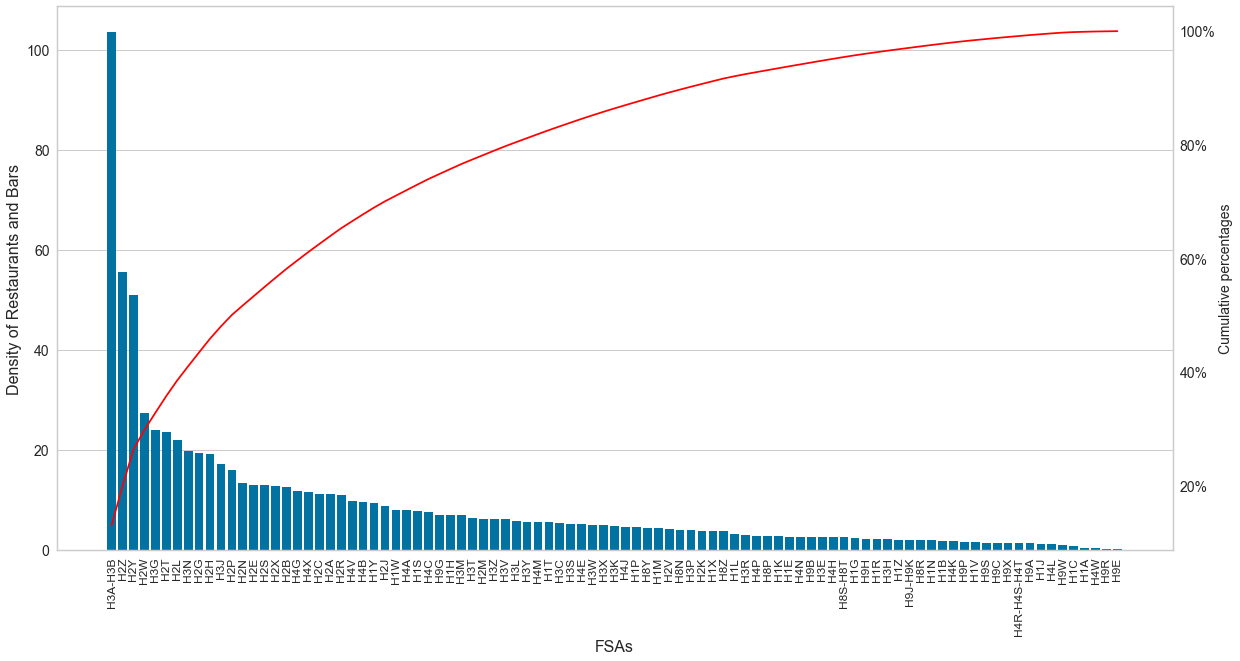

In [19]:
pareto_chart(df_env, 'RestaurantBar', 'Density of Restaurants and Bars')

Let's see a histogram of the PPS in Montreal.

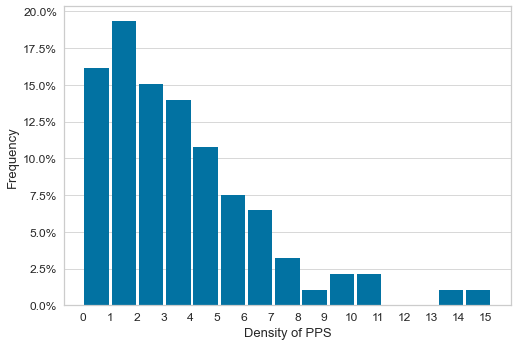

In [20]:
plot_hist(df_env, 'PPS', 15, 0, 'Density of PPS')

## Population data frame

Let's see a pareto chart of the density of population.

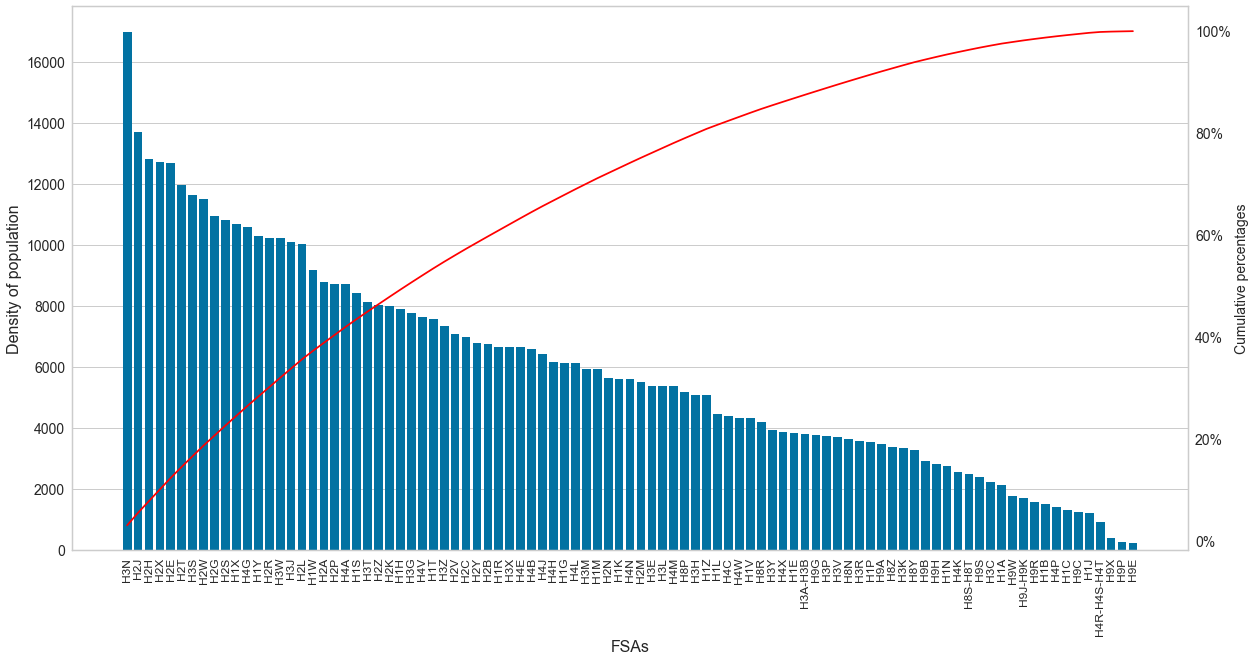

In [21]:
pareto_chart(df_pop, 'Population', 'Density of population')

Let's see a histogram of the age of population.

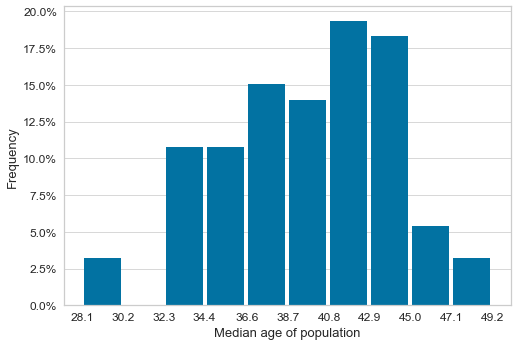

In [22]:
plot_hist(df_pop, 'Age', 10, 1, 'Median age of population')

## Housing data frame

Let's see a pareto chart of the value of the real estate properties.

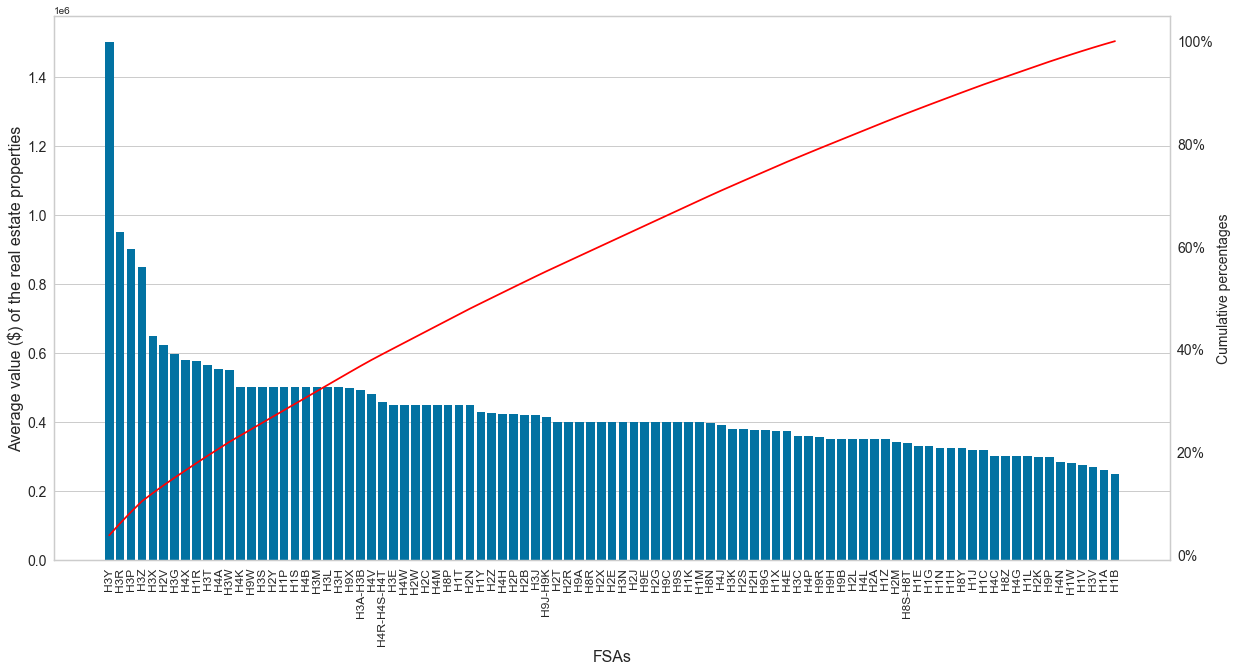

In [23]:
pareto_chart(df_hous, 'Value($)', 'Average value ($) of the real estate properties')

Let's see a histogram of the average number of rooms in the dwellings.

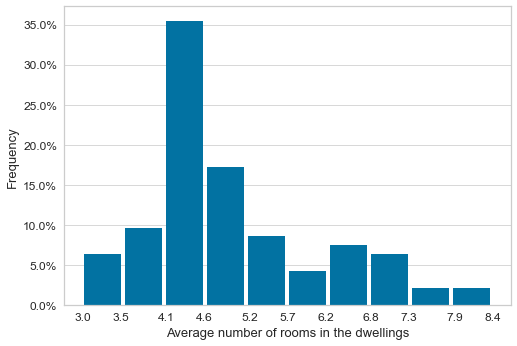

In [24]:
plot_hist(df_hous, 'NbRooms', 10, 1, 'Average number of rooms in the dwellings')

# Clustering

## K-Means

Environment


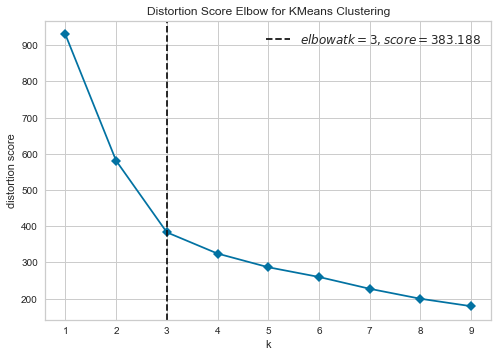

Population


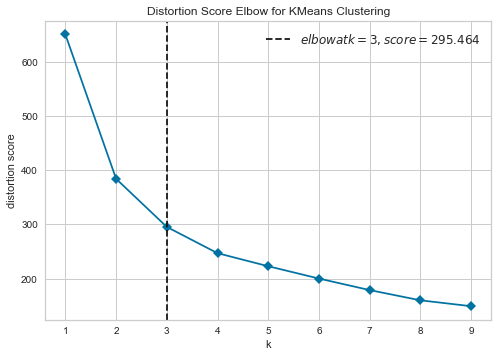

Housing


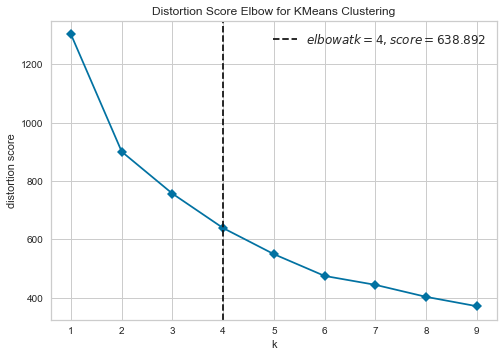

In [25]:
def apply_kmeans(df):
    # Data scaling (making sure to drop potential columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))
    # Get the optimal number of clusters for KMeans using the elbow method
    visualizer = KElbowVisualizer(KMeans(), k=(1,10), metric='distortion', timings=False).fit(X)
    k_cluster = visualizer.elbow_value_
    visualizer.show()
    # Run KMeans model and get the clusters label
    kmeans = KMeans(n_clusters=k_cluster, init='k-means++', n_init=15).fit(X)
    df['Cluster_kmeans'] = kmeans.labels_
    # Get the silhouette score to measure and compare the performance
    silhouette = metrics.silhouette_score(X, kmeans.labels_, metric='euclidean')
    
    return df, silhouette

silhouette_env = {}
silhouette_pop = {}
silhouette_hous = {}
print('Environment')
df_env, silhouette_env['kmeans'] = apply_kmeans(df_env)
print('Population')
df_pop, silhouette_pop['kmeans'] = apply_kmeans(df_pop)
print('Housing')
df_hous, silhouette_hous['kmeans'] = apply_kmeans(df_hous)

## DBSCAN

Environment


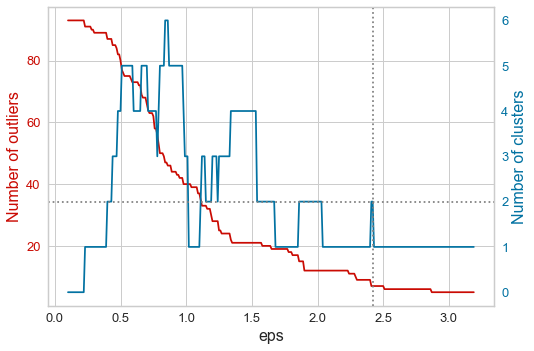

Population


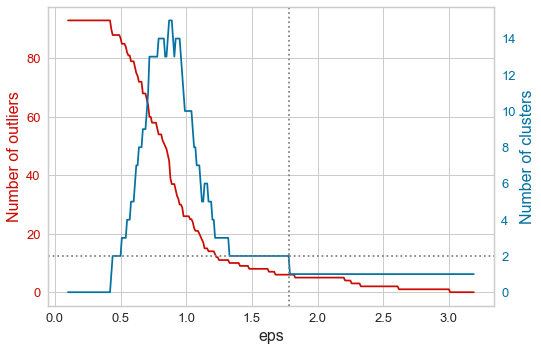

Housing


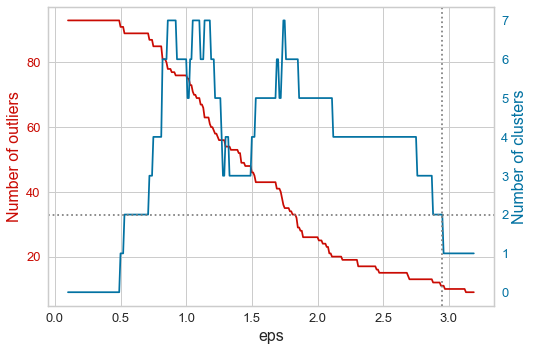

In [121]:
def get_dbscan_parameters(df, min_pts):
    eps_min = 0.1
    eps_max = 3.2
    step = 0.01

    # Data scaling (making sure to drop potential columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))
    
    # Determine the optimal value for eps
    nb_outliers = []
    nb_clusters = []
    silhouette = []
    EPS = np.arange(eps_min, eps_max, step)
    for eps in EPS:
        dbscan = DBSCAN(eps=eps, min_samples=min_pts, metric='euclidean').fit(X)
        unique, counts = np.unique(dbscan.labels_, return_counts=True)
        value_counts = np.asarray((unique, counts)).T
        if -1 in value_counts: # if there are outliers
            nb_outliers.append(value_counts[0][1])
            nb_clusters.append(value_counts.shape[0] - 1)
        else: # if no outliers
            nb_outliers.append(0)
            nb_clusters.append(value_counts.shape[0])

    # Get the best value for eps (minimum number of outliers and more than one cluster)
    eps = EPS[[i for i,v in enumerate(nb_clusters) if v > 1][-1]]
    
    # Plot
    fig, ax1 = plt.subplots()
    # Number of outliers
    ax1.set_xlabel('eps', fontsize=16)
    ax1.set_ylabel('Number of outliers', color='r', fontsize=16)
    ax1.plot(EPS, nb_outliers, 'r-')
    ax1.tick_params(axis='y', labelcolor='r', labelsize=13)
    ax1.tick_params(labelsize=13)
    # Number of clusters
    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of clusters', color='b', fontsize=16)
    ax2.plot(EPS, nb_clusters, 'b-')
    ax2.tick_params(axis='y', labelcolor='b', labelsize=13)
    ax2.tick_params(labelsize=13)
    ax2.grid(False)
    # Show the selected point
    plt.axvline(x=eps, color='grey', linestyle=':')
    plt.axhline(y=nb_clusters[np.where(EPS == eps)[0][0]], color='grey', linestyle=':')
    plt.show()
    
    
    return eps


def apply_dbscan(df, eps, min_pts):
    # Data scaling (making sure to drop potential columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))
    # Run DBSCAN model and get the clusters label
    dbscan = DBSCAN(eps=eps, min_samples=min_pts, metric='euclidean').fit(X)
    df['Cluster_DBSCAN'] = dbscan.labels_
    # Get the silhouette score to measure and compare the performance
    silhouette = metrics.silhouette_score(X, dbscan.labels_, metric='euclidean')
    
    return df, silhouette

min_pts = 2
# Get the eps value for each dataset
print('Environment')
eps_env = get_dbscan_parameters(df_env, min_pts)
print('Population')
eps_pop = get_dbscan_parameters(df_pop, min_pts)
print('Housing')
eps_hous = get_dbscan_parameters(df_hous, min_pts)
# Run the DBSCAN model for each dataset
df_env, silhouette_env['DBSCAN'] = apply_dbscan(df_env, eps_env, min_pts)
df_pop, silhouette_pop['DBSCAN'] = apply_dbscan(df_pop, eps_pop, min_pts)
df_hous, silhouette_hous['DBSCAN'] = apply_dbscan(df_hous, eps_hous, min_pts)

In [120]:
df_hous[df_hous['Cluster_DBSCAN'] == -1].describe().round(1)

NbDwellings   Value($)  NbRooms  Rental(%)  DetachedHouse(%)  \
count         11.0       11.0     11.0       11.0              11.0   
mean        1702.7   524292.8      5.2       39.6              22.4   
std         1627.6   329654.6      2.0       22.4              31.5   
min           89.6   317604.0      3.3       10.3               0.0   
25%          512.1   379904.0      3.6       17.9               0.0   
50%         1293.3   450348.0      4.5       42.1               5.4   
75%         2396.6   497795.2      6.6       51.6              35.4   
max         5000.0  1500249.0      8.4       74.0              86.3   

       AttachedHouse(%)  Apartment(%)  1960OrBefore(%)  1961-1980(%)  \
count              11.0          11.0             11.0          11.0   
mean               14.9          62.7             24.5          20.7   
std                17.5          39.5             25.5          14.2   
min                 0.2           4.9              2.6           4.2   
25%                 2.2          19.3              7.5           8.4   
50%                 8.8          81.0             17.4          18.5   
75%                20.3          97.8             27.4          27.5   
max                53.6          99.8             89.0          49.5   

       1981-1990(%)  1991-2000(%)  2001-2005(%)  2006-2010(%)  2011-2016(%)  \
count          11.0          11.0          11.0          11.0          11.0   
mean           11.2           9.8           7.3          10.6          15.9   
std             7.9           7.6           5.3           7.8          15.1   
min             1.2           0.9           0.3           0.0           1.5   
25%             6.4           3.8           1.8           3.4           6.6   
50%             8.5           6.6           8.3           9.4          12.7   
75%            15.1          15.3          10.7          16.7          17.9   
max            27.5          23.4          16.1          21.7          44.4   

       Cluster_kmeans  Cluster_DBSCAN  
count            11.0            11.0  
mean              1.4            -1.0  
std               0.9             0.0  
min               0.0            -1.0  
25%               1.0            -1.0  
50%               1.0            -1.0  
75%               1.5            -1.0  
max               3.0            -1.0

## Agglomerative clustering

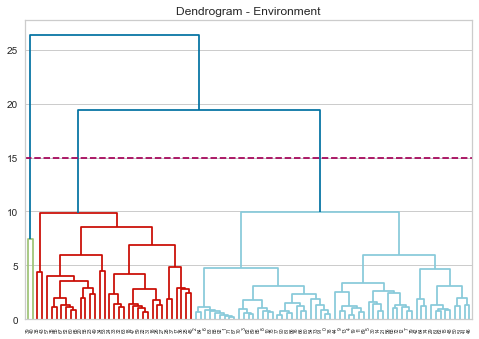

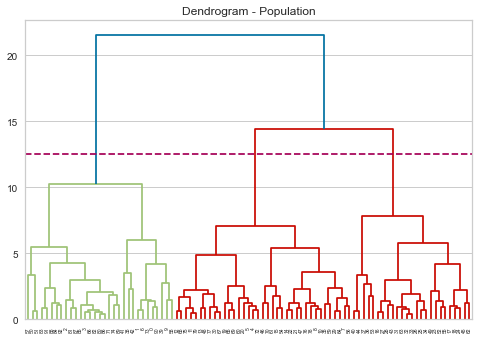

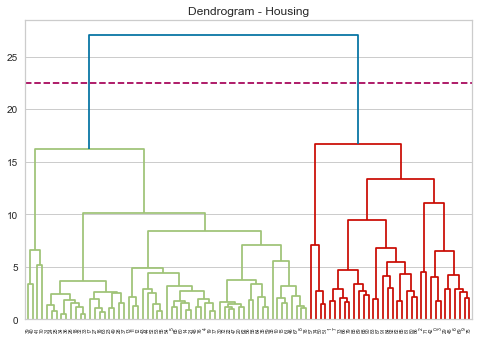

In [18]:
def plot_dendrogram(df, title, select=None):
    # Data scaling (drop columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))

    plt.figure()
    plt.grid(axis='x')
    plt.title('Dendrogram - ' + title)  
    dend = shc.dendrogram(shc.linkage(X, method='ward'))
    if select is not None:
        plt.axhline(y=select, color='m', linestyle='--')
    
    
plot_dendrogram(df_env, 'Environment', 15)
plot_dendrogram(df_pop, 'Population', 12.5)
plot_dendrogram(df_hous, 'Housing', 22.5)

In [19]:
def apply_agglomerative(df, n_cluster):
    # Data scaling (drop columns with cluster labels for modelling)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))
    # Run Agglomerative clustering model and get the clusters label
    agglo = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X)
    df['Cluster_Agglomerative'] = agglo.labels_
    # Get the silhouette score to measure and compare the performance
    silhouette = metrics.silhouette_score(X, agglo.labels_, metric='euclidean')
    
    return df, silhouette

df_env, silhouette_env['AgglomerativeClustering'] = apply_agglomerative(df_env, 3)
df_pop, silhouette_pop['AgglomerativeClustering'] = apply_agglomerative(df_pop, 3)
df_hous, silhouette_hous['AgglomerativeClustering'] = apply_agglomerative(df_hous, 2)

# Analysis

Pourcentage of information carried by the dimension-reduced data: 73.23 %


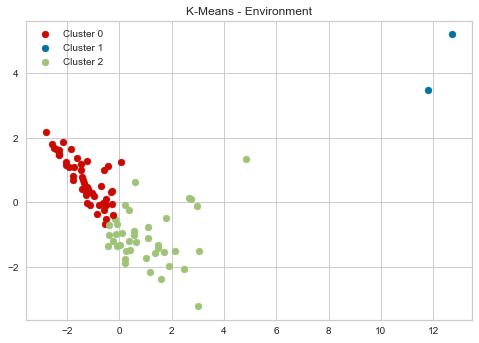

In [73]:
def plot_results(df, method, clusters, title):
    method_columns = {'K-Means': 'Cluster_kmeans',
                      'DBSCAN': 'Cluster_DBSCAN',
                      'Agglomerative Clustering': 'Cluster_Agglomerative'}
    # Data scaling (drop columns with cluster labels for PCA)
    cluster_columns = []
    for column in df.columns:
        if 'Cluster' in column:
            cluster_columns.append(column)
    X = StandardScaler().fit_transform(df.drop(columns=cluster_columns).set_index('FSA'))

    pca = PCA(n_components=2).fit(X)
    pca_2d = pca.transform(X)
    
    colors = ['r', 'b', 'g', 'c']
    legend = []
    for n in clusters:
            if n == -1:
                legend.append('Outliers')
            else:
                legend.append('Cluster ' + str(n))
    if len(clusters) == 3:
        for i in range(pca_2d.shape[0]):
            if df.loc[i, method_columns[method]] == clusters[0]:
                ax0 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c=colors[0], marker='o')
            if df.loc[i, method_columns[method]] == clusters[1]:
                ax1 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c=colors[1], marker='o')
            if df.loc[i, method_columns[method]] == clusters[2]:
                ax2 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c=colors[2], marker='o')
        plt.legend([ax0, ax1, ax2], legend)
    if len(clusters) == 4:
        for i in range(pca_2d.shape[0]):
            if df.loc[i, method_columns[method]] == clusters[0]:
                ax0 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c=colors[0], marker='o')
            if df.loc[i, method_columns[method]] == clusters[1]:
                ax1 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c=colors[1], marker='o')
            if df.loc[i, method_columns[method]] == clusters[2]:
                ax2 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c=colors[2], marker='o')
            if df.loc[i, method_columns[method]] == clusters[3]:
                ax3 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c=colors[3], marker='o')
        plt.legend([ax0, ax1, ax2, ax3], legend)
    plt.title(method + ' - ' + title)
    print('Pourcentage of information carried by the dimension-reduced data: ' +
          str(round(pca.explained_variance_ratio_.sum()*100, 2)) + ' %')
    plt.show()


df = df_env
method = 'K-Means'
clusters = [0, 1, 2]
title = 'Environment'
plot_results(df, method, clusters, title)

In [64]:
env_map = folium.Map(location=[latitude, longitude], zoom_start=10, tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(env_map)
folium.Choropleth(
    geo_data=mtl_grp_geo_json,
    data=df_env,
    columns=['FSA', 'Cluster_kmeans'],
    key_on='feature.properties.FSAGROUP',
    fill_color='RdYlBu',
    fill_opacity=0.7, 
    line_opacity=0.2,
    bins=[0, 1, 2, 3],
    legend_name='Cluster',
).add_to(env_map)

env_map